# Modeling - Aggregate Dataset after removing collinear features

### Home credit risk assessment models
In this notebook we will train and test these models for the problem of credit risk assessment

- Baseline using Logistic regression
- Improved model using Random forest
- Light Gradient Boosting Machine

We will train the different models with separate datasets holding different engineered features like:
- Dataset without additional features 
- Dataset with domain knowladge features
- Dataset with aggregated features before removing collinear features
- Dataset with aggregated features after removing collinear features

In [1]:
## Imports 
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Dataset without additional features

In [2]:
train = pd.read_csv("./train_bureau_corrs_removed.csv")
test = pd.read_csv("./test_bureau_corrs_removed.csv")


#### Preparing the dataset for feeding into the model
- Feature Imputing
- Feature Scaling 

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Drop the target from the training data
if 'TARGET' in train:
    train_labels = train['TARGET']
    train = train.drop(columns = ['TARGET'])
else:
    train = train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = test.copy()

# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan,strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 314)
Testing data shape:  (48744, 314)


#### Split the training set to validation and train set

In [4]:
from sklearn.model_selection import train_test_split

X_training_set, X_validation_set, y_training_set, y_validation_set = train_test_split(train, 
                                                                                      train_labels, test_size=0.33, random_state=42)

### Baseline model using Logistic regression

I believe to be able to get a good model we need to start with a basic baseline model that we can compare other advanced model with. One can assume that for this type of problems we could guess the same value for all examples on the testing set.

Since we are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. For our problem we will use the Reciever Operating Characteristic Area Under the Curve (AUC ROC) metric to judge our models incase of the baseline model it will be 0.5 

In [5]:
# Starting with Logistic Regression.

from sklearn.linear_model import LogisticRegression

logistic_regressor = LogisticRegression(C = 0.0001)

The only change we will make from the default model settings is to lower the regularization parameter, C, which controls the amount of overfitting (a lower value should decrease overfitting). This will get us slightly better results than the default LogisticRegression, but it still will set a low bar for any future models

In [6]:
logistic_regressor.fit(X_training_set,y_training_set)

LogisticRegression(C=0.0001)

In [7]:
log_regression_pred = logistic_regressor.predict(X_validation_set)

In [8]:
from sklearn.metrics import accuracy_score,classification_report, roc_auc_score
print("The accuracy in general is : ", accuracy_score(y_validation_set,log_regression_pred))
print("\n")
print("The classification report is as follows:\n", classification_report(y_validation_set,log_regression_pred))
print("ROC AUC score is: ",roc_auc_score(y_validation_set,log_regression_pred))

The accuracy in general is :  0.9200130076173395


The classification report is as follows:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     93362
           1       0.00      0.00      0.00      8117

    accuracy                           0.92    101479
   macro avg       0.46      0.50      0.48    101479
weighted avg       0.85      0.92      0.88    101479

ROC AUC score is:  0.5


c:\users\hebaa\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\hebaa\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\hebaa\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Improved model using Random forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators = 500, random_state = 50, verbose = 1, n_jobs = -1)

In [10]:
random_forest.fit(X_training_set,y_training_set)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.6min finished


RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=50, verbose=1)

In [11]:
random_forest_pred = random_forest.predict(X_validation_set)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    2.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    5.1s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    5.9s finished


In [12]:
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score
print("The accuracy in general is : ", accuracy_score(y_validation_set,random_forest_pred))
print("\n")
print("The classification report is as follows:\n", classification_report(y_validation_set,random_forest_pred))
print("ROC AUC score is: ",roc_auc_score(y_validation_set,random_forest_pred))

The accuracy in general is :  0.9200524246395806


The classification report is as follows:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     93362
           1       0.83      0.00      0.00      8117

    accuracy                           0.92    101479
   macro avg       0.88      0.50      0.48    101479
weighted avg       0.91      0.92      0.88    101479

ROC AUC score is:  0.5003026400669096


Since that random forest acts as a feature selector model we will visualize the important features selected by training this model on the dataset

In [13]:
feature_importance_df = pd.DataFrame({'Feature':features,'Importance':random_forest.feature_importances_})

In [14]:
def plot_importance(df):
    """
    Builds the dataset to plot the feature importance.
    
    """
    # Sort features according to importance
    df = df.sort_values(['Importance'],ascending=False).reset_index()
    
    # drop the old index to avoid confusion
    df = df.drop(['index'],axis=1)
    
    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 9))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:30]))), 
            df['Importance'].head(30), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:30]))))
    ax.set_yticklabels(df['Feature'].head(30))
    
    plt.xlabel("Normalized feature importance")
    plt.ylabel("Features")
    
    plt.show()
    return df

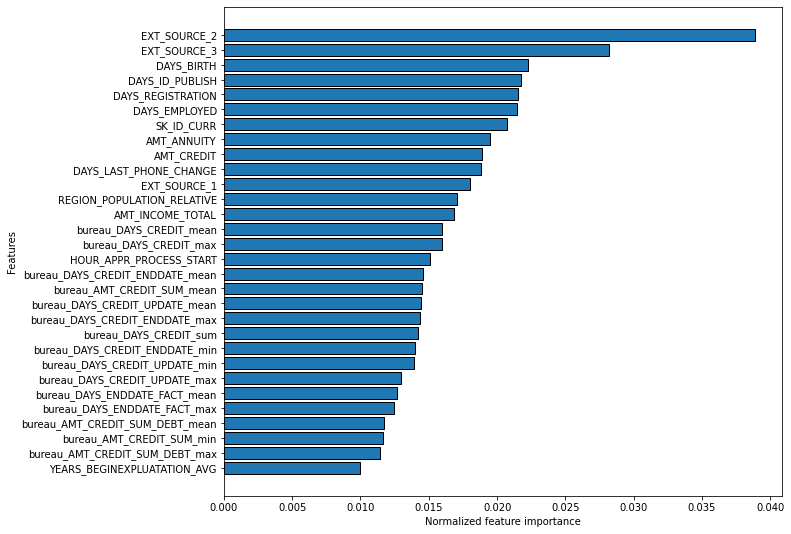

In [15]:
sorted_importance = plot_importance(feature_importance_df)

We see that there are only a handful of features with a significant importance to the model, which suggests we may be able to drop many of the features without a decrease in performance (and we may even see an increase in performance.)

After removing collinear features we can see that more od the top 20 most important features came from us.

In [16]:
sorted_importance.head(20)

,Feature,Importance
0,EXT_SOURCE_2,0.038896
1,EXT_SOURCE_3,0.028193
2,DAYS_BIRTH,0.022262
3,DAYS_ID_PUBLISH,0.021765
4,DAYS_REGISTRATION,0.021543
5,DAYS_EMPLOYED,0.021432
6,SK_ID_CURR,0.020728
7,AMT_ANNUITY,0.019473
8,AMT_CREDIT,0.018888
9,DAYS_LAST_PHONE_CHANGE,0.018830


<b>Examining the feature improtances, it looks as if a few of the feature we constructed are among the most important !!!</b>

### Light Gradient Boosting Machine

While research about the problem in hand I came accross multiple kaggle competition that was won by light gradient boosting machine so I decided to try it on our problem as well.

https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics


In [4]:
submission, fi, metrics = model(train, test)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 313)
Testing Data Shape:  (48744, 313)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.806889	train's binary_logloss: 0.539846	valid's auc: 0.760975	valid's binary_logloss: 0.55625
Early stopping, best iteration is:
[218]	train's auc: 0.810266	train's binary_logloss: 0.536378	valid's auc: 0.76117	valid's binary_logloss: 0.554033
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.806991	train's binary_logloss: 0.540071	valid's auc: 0.762072	valid's binary_logloss: 0.556645
Early stopping, best iteration is:
[249]	train's auc: 0.816055	train's binary_logloss: 0.530946	valid's auc: 0.762419	valid's binary_logloss: 0.551003
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.806092	train's binary_logloss: 0.54114	valid's auc: 0.767279	valid's binary_logloss: 0.557499
Early stopping, best iteration is:
[273]	train's auc: 0.819302	train's binary_logloss: 0.528093	v

In [5]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

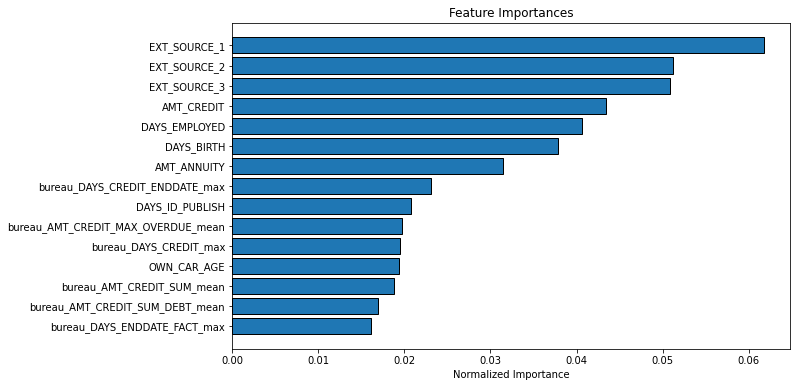

In [6]:
fi_sorted = plot_feature_importances(fi)


Again <b>Light Gradient Boosting Machine</b> is out performing the baseline model with a few of our aggregated features on the top 10 most important features. This only proves that we are going on the rigt track of creating our own features.